In [1]:
import os
import copy
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt 

from dekef.base_density import *

from IFdensity.contam_sm_de import *
from IFdensity.influence_function import *

from IPython.display import Markdown as md

In [2]:
os.chdir('/Users/chenxizhou/Dropbox/code_package/IFdensity')
true_data = np.load('data/geyser.npy').astype(np.float64)
df = copy.deepcopy(true_data[:, 0]).reshape(-1, 1)

# original data with 108.0 removed 
data_waiting = df[df != 108.0]

# bandwidth parameter in the Gaussian kernel function
bw = 7.0

# penalty parameter 
log_pen_param = -10.0

# base density 
base_density = BasedenGamma(np.load('data/geyser.npy').astype(np.float64)[:, 0])

plot_kwargs = plot_IF_1d_params(x_limit=(21., 410.), plot_pts_cnt = 2000)

--------------------------------------------------
Current contaminated data point is 120.0.


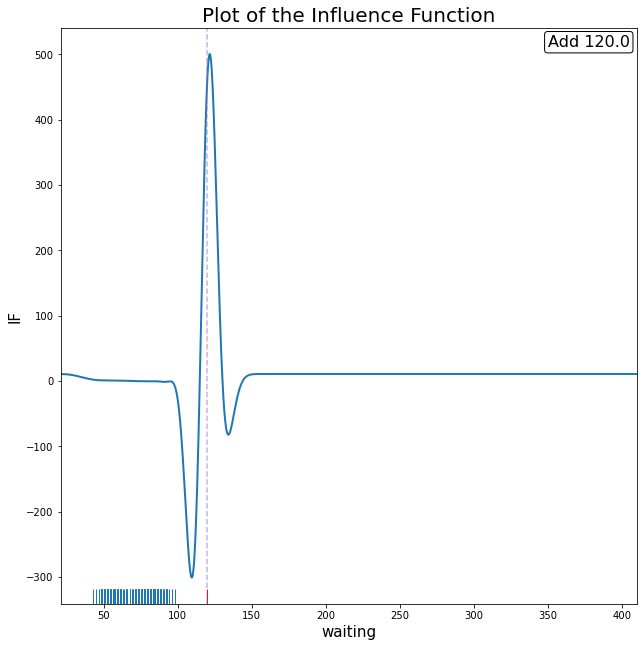

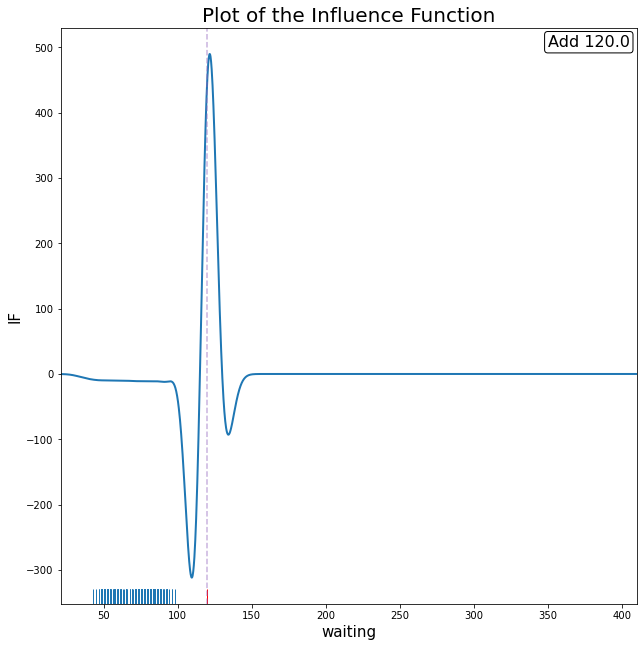

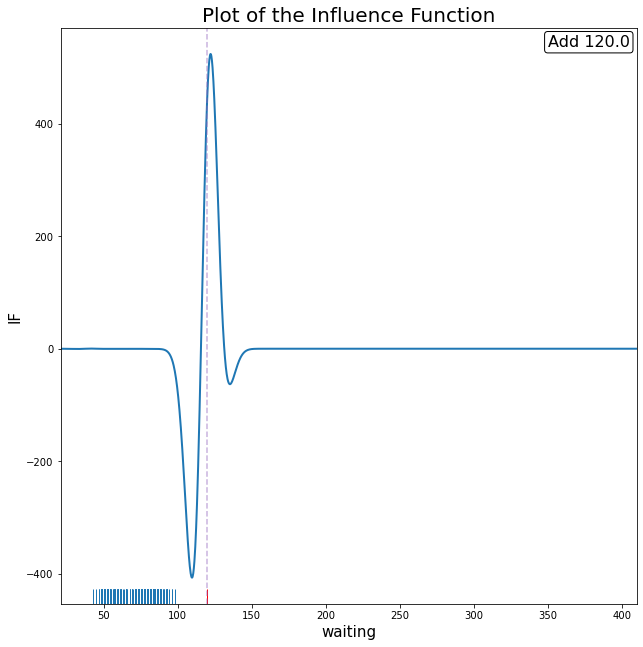

--------------------------------------------------
Current contaminated data point is 130.0.


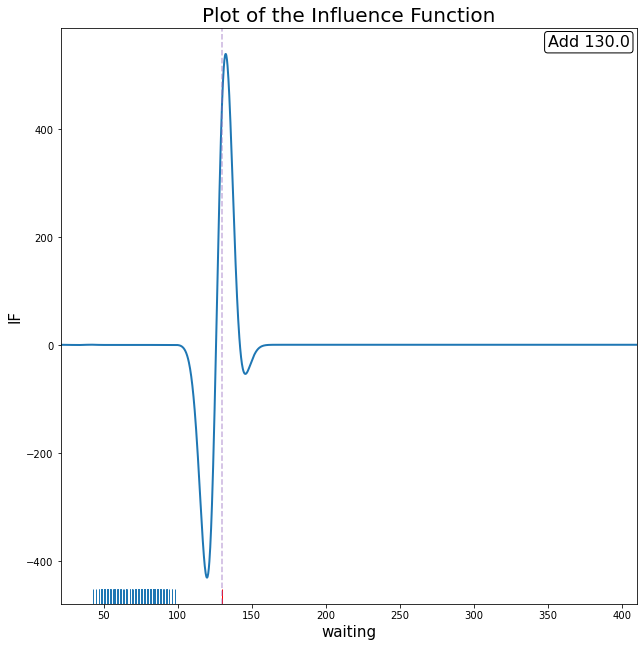

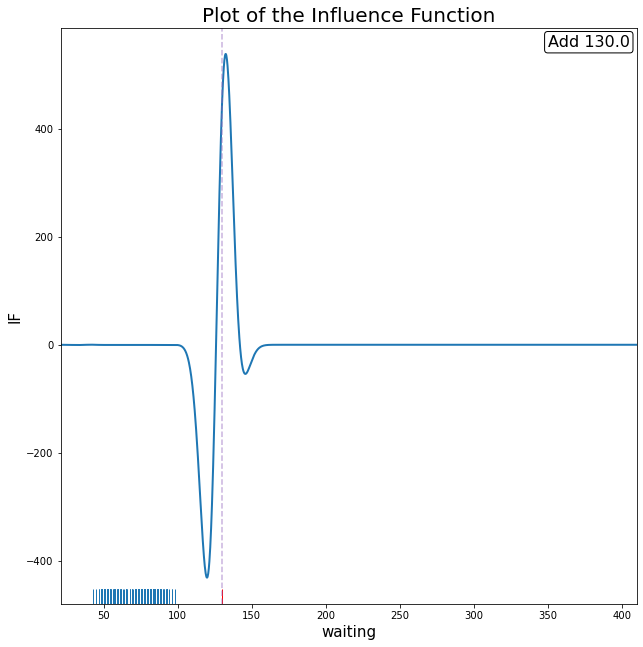

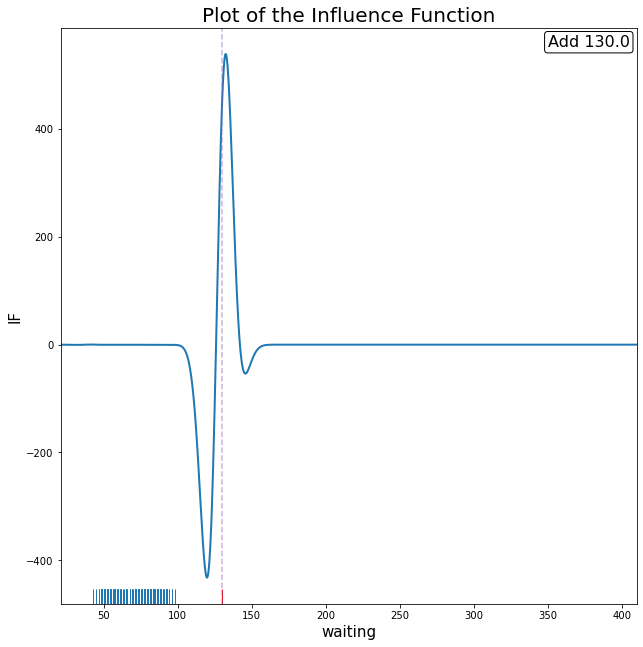

--------------------------------------------------
Current contaminated data point is 140.0.


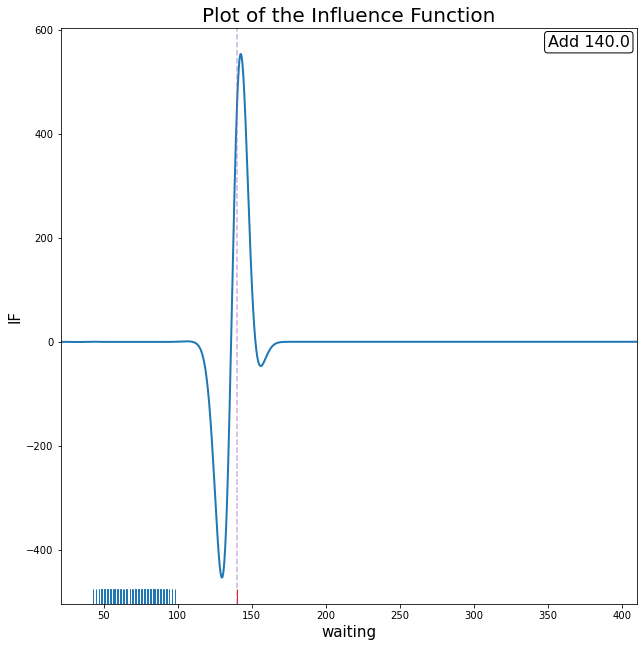

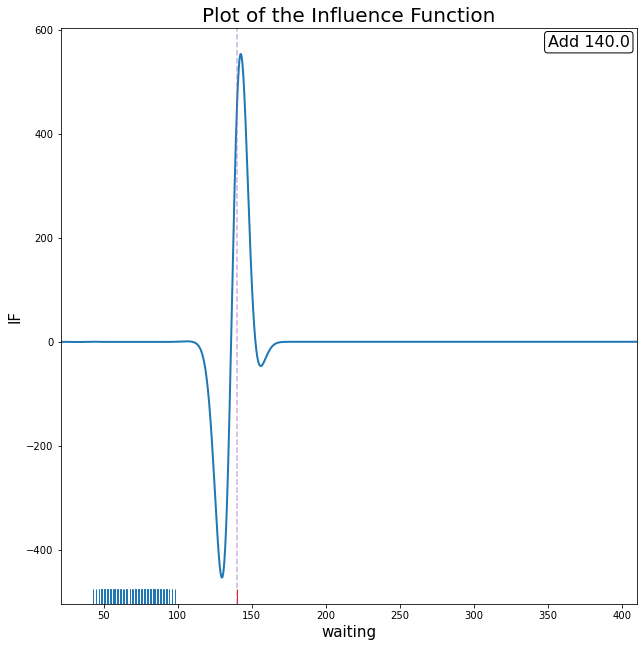

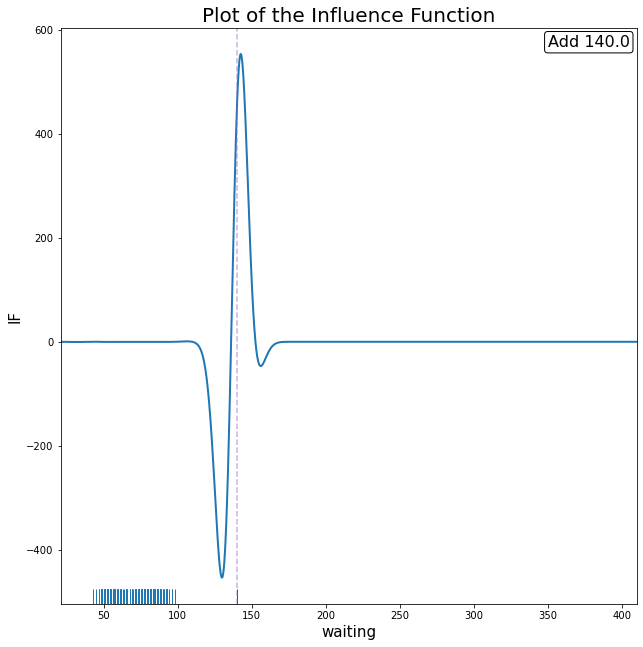

--------------------------------------------------
Current contaminated data point is 150.0.


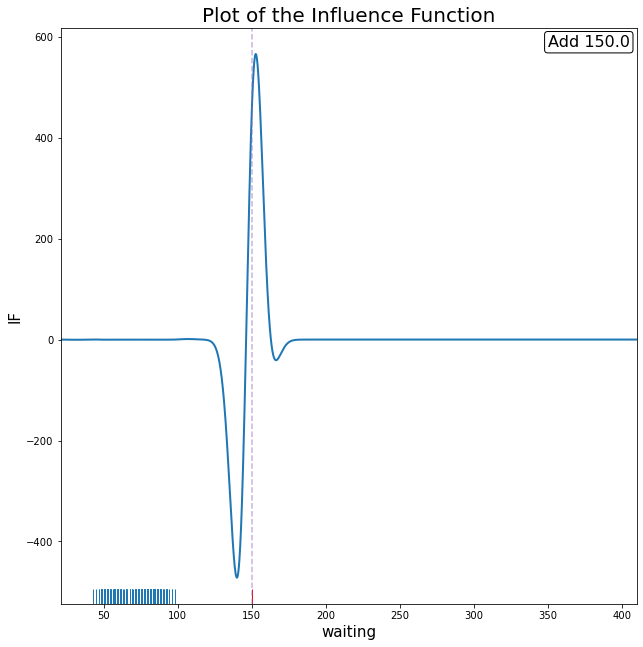

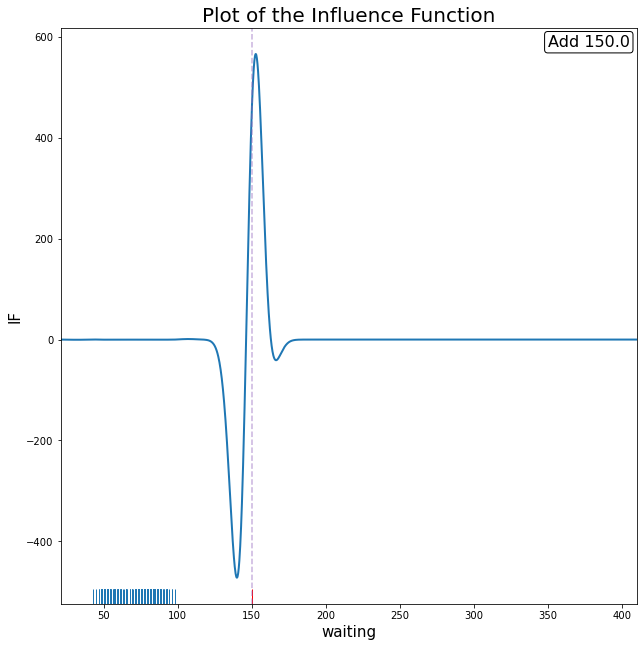

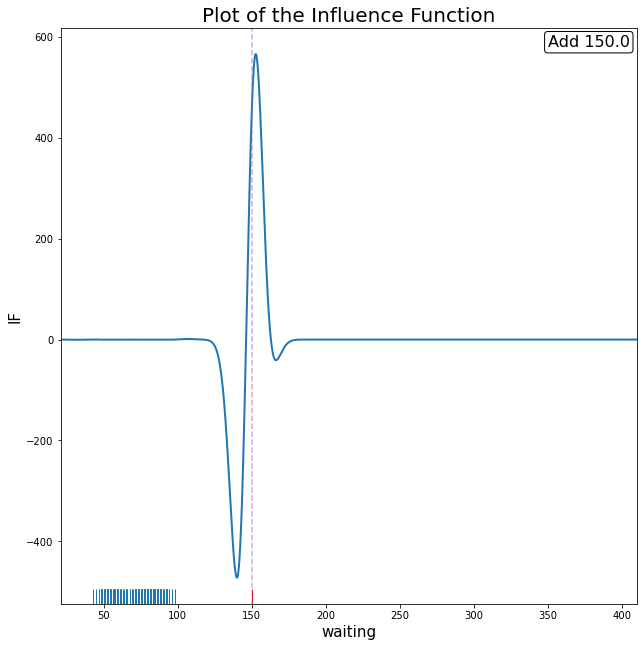

--------------------------------------------------
Current contaminated data point is 160.0.


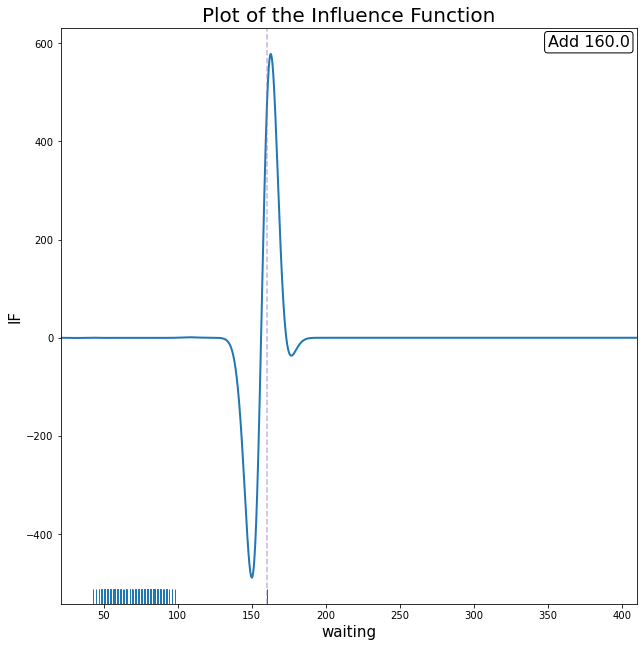

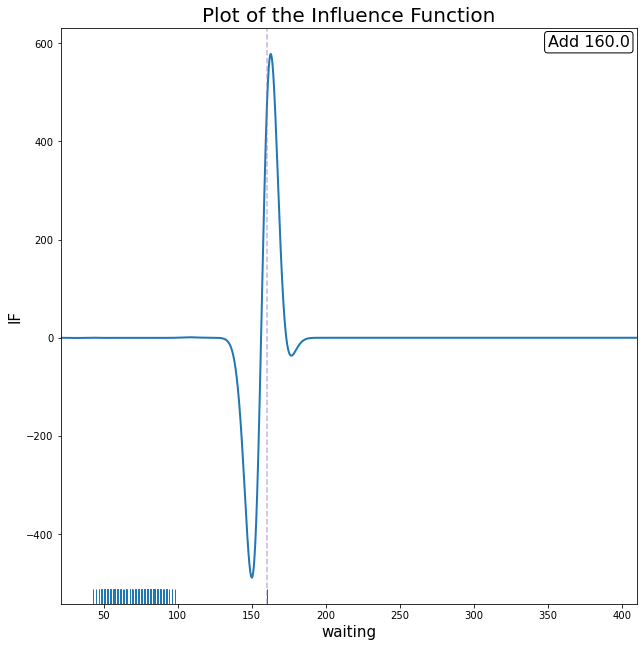

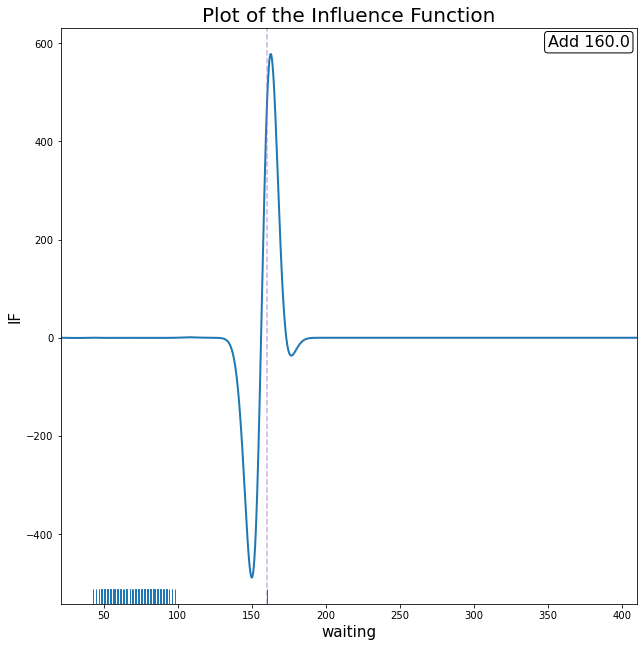

--------------------------------------------------
Current contaminated data point is 170.0.


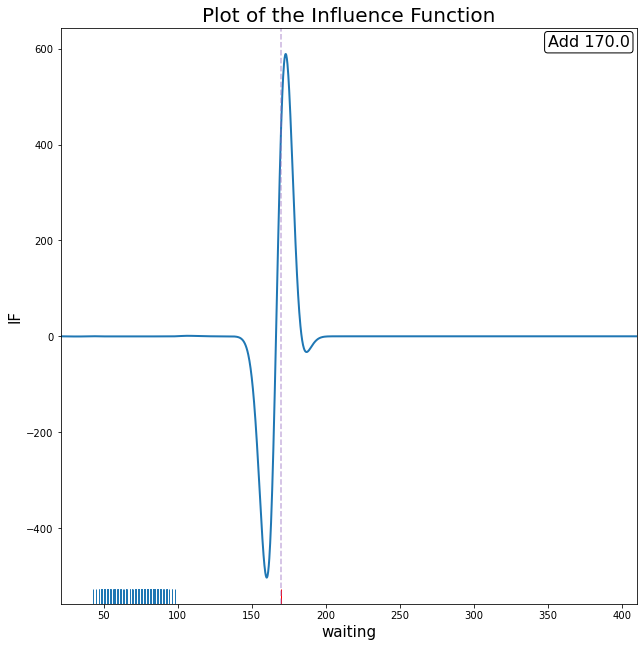

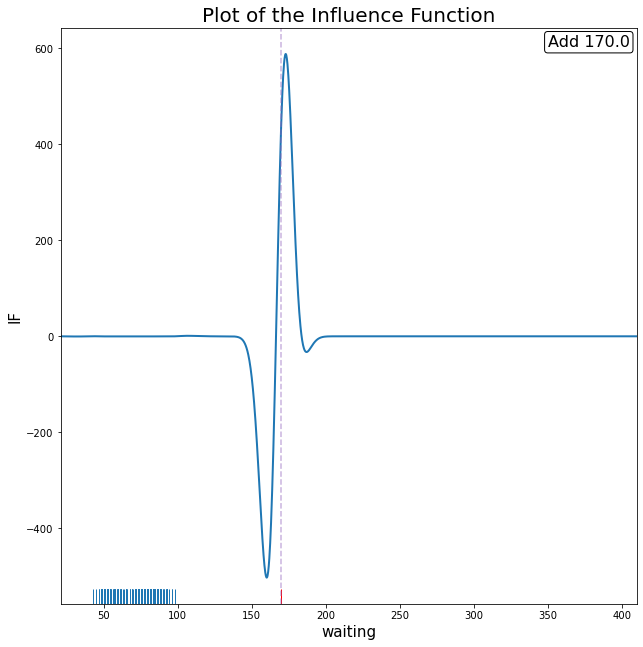

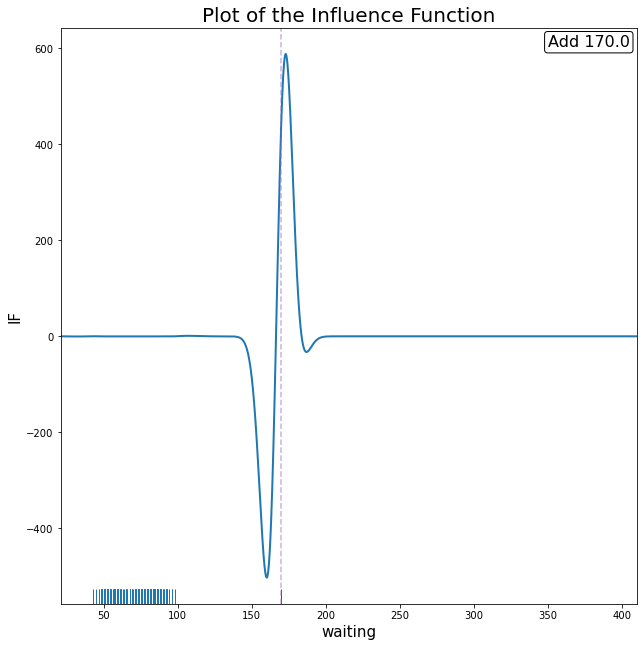

--------------------------------------------------
Current contaminated data point is 180.0.


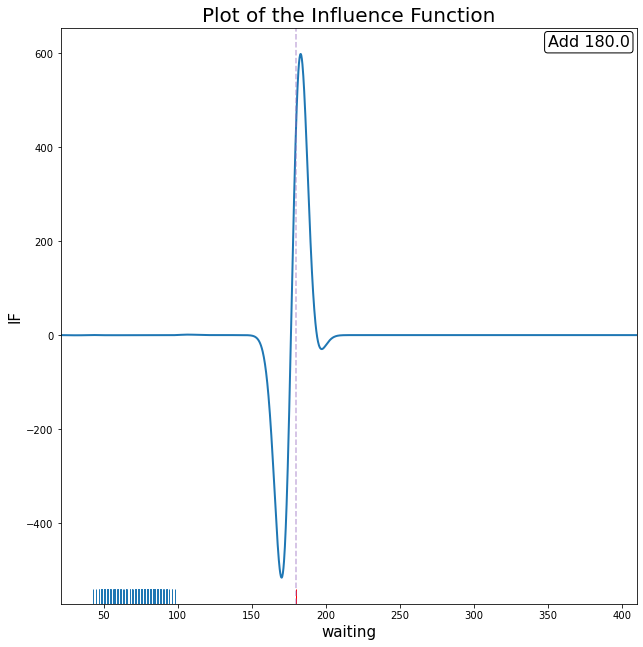

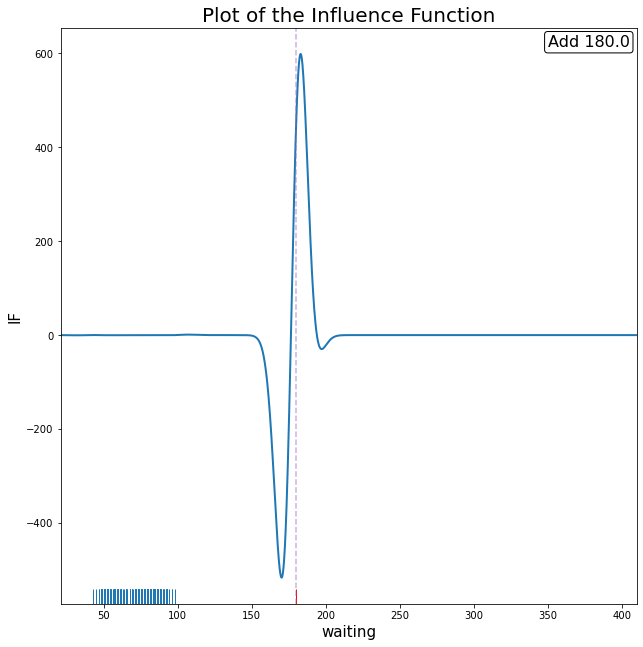

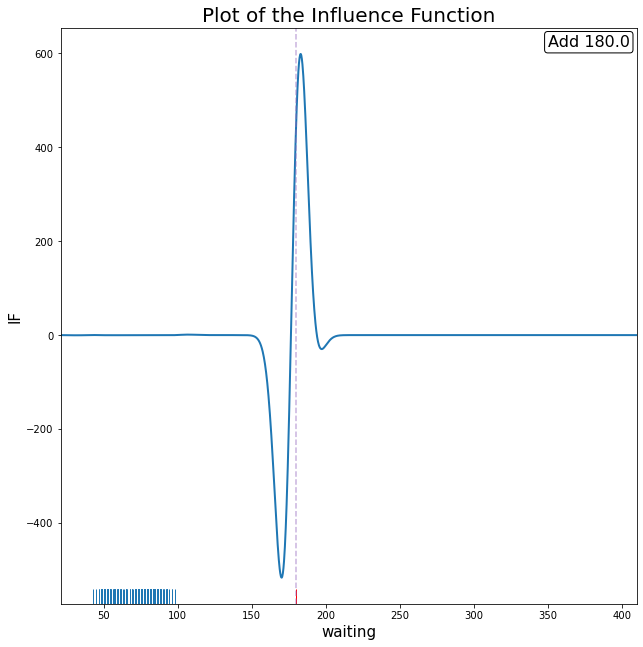

--------------------------------------------------
Current contaminated data point is 190.0.


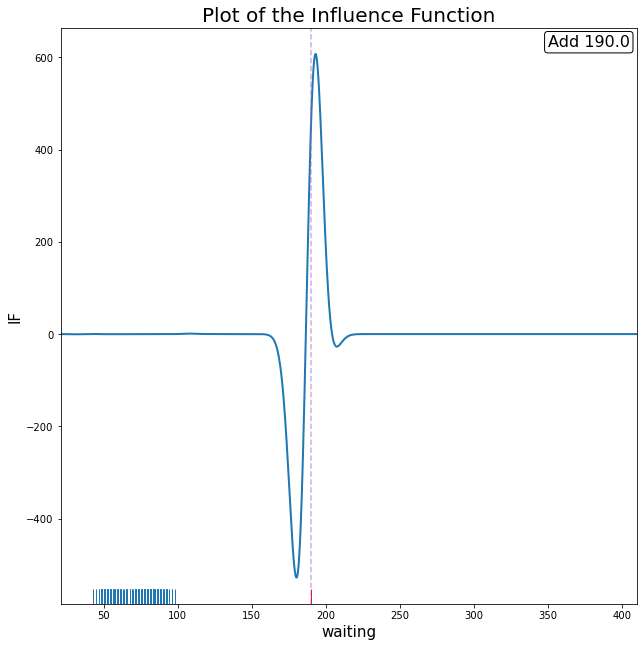

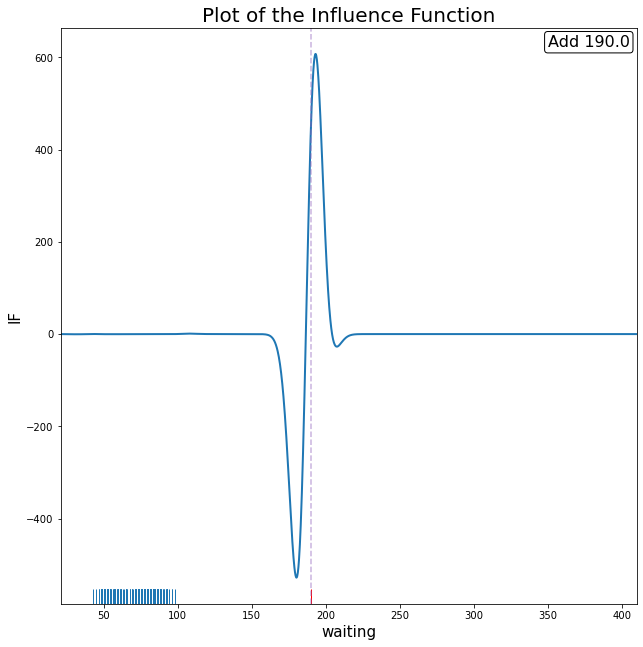

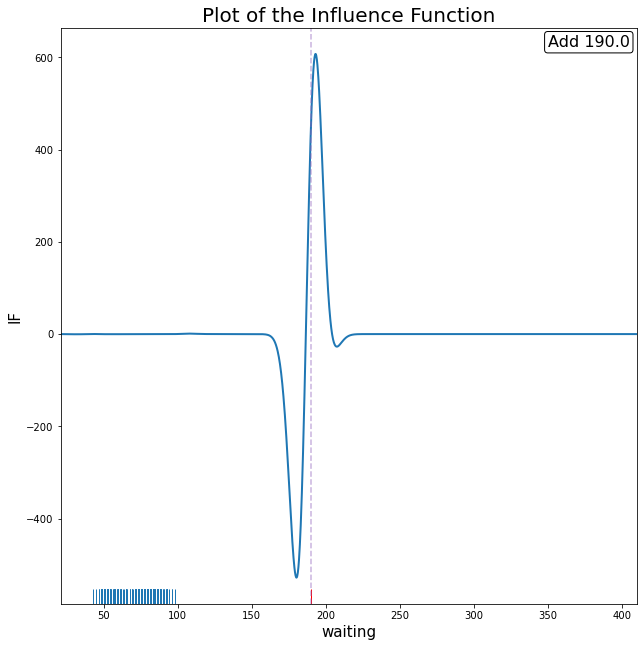

In [3]:
# contaminated data 
contam_data_list = np.arange(120., 200., 10)
if_norm = []
if_limit_norm = []
for contam_pt in contam_data_list: 
    
    print('-' * 50)
    print(f'Current contaminated data point is {contam_pt}.')
    
    contam_data = np.array([[contam_pt]])
    
    ifun = SMInfluenceFunction(
        data = data_waiting, 
        contam_data = contam_data, 
        contam_weight = 1e-8, 
        penalty_param = np.exp(log_pen_param), 
        base_density = base_density, 
        bw = bw)
    
    
    ifun1 = ifun.plot_IF_logdensity_1d(plot_kwargs, 'waiting')
    ifun2 = ifun.plot_IF_natparam_1d(plot_kwargs, 'waiting')
    ifun3 = ifun.plot_IF_natparam_limit_1d(plot_kwargs, 'waiting')
    
#     if_norm.append(ifun.eval_IF_natparam_norm())

#     if_limit_norm.append(ifun.eval_IF_natparam_limit_norm_1d())

# plt.plot(contam_data_list, if_norm, 'b-')
# plt.plot(contam_data_list, if_limit_norm, 'r-')

In [ ]:
# contaminated data 
contam_data_list = np.arange(90000000., 90005000., 200)
if_norm = []
if_limit_norm = []
for contam_pt in contam_data_list: 
    
    print('-' * 50)
    print(f'Current contaminated data point is {contam_pt}.')
    
    contam_data = np.array([[contam_pt]])
    
    ifun = SMInfluenceFunction(
        data = data_waiting, 
        contam_data = contam_data, 
        contam_weight = 1e-8, 
        penalty_param = np.exp(log_pen_param), 
        base_density = base_density, 
        bw = bw)
    
    if_norm.append(ifun.eval_IF_natparam_norm())

    if_limit_norm.append(ifun.eval_IF_natparam_limit_norm_1d())
            

In [ ]:
plt.plot(contam_data_list, if_norm, 'b-')
plt.plot(contam_data_list, if_limit_norm, 'r-')

In [ ]:
contam_pt = 250.
contam_data = np.array([[contam_pt]])
ifun = SMInfluenceFunction(
        data = data_waiting, 
        contam_data = contam_data, 
        contam_weight = 1e-8, 
        penalty_param = np.exp(log_pen_param), 
        base_density = base_density, 
        bw = bw)

In [ ]:
ifun.contam_density.kernel_function_data.bw

In [ ]:
ifun.contam_density.kernel_function_data.partial_kernel_matrix_22(new_data = data_waiting.reshape(-1, 1))

In [ ]:
3/7**4